# BIDMach: parameter tuning

In this notebook we'll explore automated parameter exploration by grid search. 

In [1]:
import BIDMat.{CMat,CSMat,DMat,Dict,IDict,FMat,FND,GDMat,GMat,GIMat,GSDMat,GSMat,HMat,Image,IMat,Mat,SMat,SBMat,SDMat}
import BIDMat.MatFunctions._
import BIDMat.SciFunctions._
import BIDMat.Solvers._
import BIDMat.JPlotting._
import BIDMach.Learner
import BIDMach.models.{FM,GLM,KMeans,KMeansw,ICA,LDA,LDAgibbs,NMF,RandomForest,SFA}
import BIDMach.datasources.{MatSource,FileSource,SFileSource}
import BIDMach.mixins.{CosineSim,Perplexity,Top,L1Regularizer,L2Regularizer}
import BIDMach.updaters.{ADAGrad,Batch,BatchNorm,IncMult,IncNorm,Telescoping}
import BIDMach.causal.{IPTW}

Mat.checkMKL
Mat.checkCUDA
Mat.setInline
if (Mat.hasCUDA > 0) GPUmem

1 CUDA device found, CUDA version 7.0


(0.96885055,11703132160,12079398912)

## Dataset: Reuters RCV1 V2

The dataset is the widely used Reuters news article dataset RCV1 V2. This dataset and several others are loaded by running the script <code>getdata.sh</code> from the BIDMach/scripts directory. The data include both train and test subsets, and train and test labels (cats). 

In [2]:
var dir = "../data/rcv1/"             // adjust to point to the BIDMach/data/rcv1 directory
tic
val train = loadSMat(dir+"docs.smat.lz4")
val cats = loadFMat(dir+"cats.fmat.lz4")
val test = loadSMat(dir+"testdocs.smat.lz4")
val tcats = loadFMat(dir+"testcats.fmat.lz4")
toc

2.701

First lets enumerate some parameter combinations for learning rate and time exponent of the optimizer (texp)

In [3]:
val lrates = col(0.03f, 0.1f, 0.3f, 1f)        // 4 values
val texps = col(0.3f, 0.4f, 0.5f, 0.6f, 0.7f)  // 5 values

  0.30000
  0.40000
  0.50000
  0.60000
  0.70000


The next step is to enumerate all pairs of parameters. We can do this using the kron operator for now, this will eventually be a custom function:

In [4]:
val lrateparams = ones(texps.nrows, 1) ⊗ lrates
val texpparams = texps ⊗ ones(lrates.nrows,1)
lrateparams \ texpparams

  0.030000   0.30000
   0.10000   0.30000
   0.30000   0.30000
         1   0.30000
  0.030000   0.40000
   0.10000   0.40000
   0.30000   0.40000
         1   0.40000
        ..        ..


Here's the learner again:

In [5]:
val (mm, opts) = GLM.learner(train, cats, GLM.logistic)

BIDMach.models.GLM$LearnOptions@6b5370

To keep things simple, we'll focus on just one category and train many models for it. The "targmap" option specifies a mapping from the actual base categories to the model categories. We'll map from category six to all our models:

In [6]:
val nparams = lrateparams.length
val targmap = zeros(nparams, 103)
targmap(?,6) = 1

   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0...
  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..


In [7]:
opts.targmap = targmap
opts.lrate = lrateparams
opts.texp = texpparams

  0.30000
  0.30000
  0.30000
  0.30000
  0.40000
  0.40000
  0.40000
  0.40000
       ..


In [8]:
mm.train

corpus perplexity=5582.125391
pass= 0
 2.00%, ll=-0.69315, gf=0.690, secs=0.4, GB=0.02, MB/s=52.25, GPUmem=0.952270
16.00%, ll=-0.40496, gf=3.711, secs=0.5, GB=0.13, MB/s=249.38, GPUmem=0.952270
30.00%, ll=-0.37984, gf=5.572, secs=0.7, GB=0.25, MB/s=370.40, GPUmem=0.952270
44.00%, ll=-0.31457, gf=6.909, secs=0.8, GB=0.36, MB/s=458.01, GPUmem=0.952270
58.00%, ll=-0.34047, gf=5.539, secs=1.3, GB=0.48, MB/s=366.89, GPUmem=0.952270
72.00%, ll=-0.23351, gf=6.221, secs=1.4, GB=0.59, MB/s=411.20, GPUmem=0.952270
87.00%, ll=-0.28147, gf=6.509, secs=1.6, GB=0.70, MB/s=430.23, GPUmem=0.952270
100.00%, ll=-0.23005, gf=6.995, secs=1.8, GB=0.81, MB/s=460.66, GPUmem=0.952009
pass= 1
 2.00%, ll=-0.28089, gf=7.081, secs=1.8, GB=0.83, MB/s=467.88, GPUmem=0.952009
16.00%, ll=-0.22614, gf=7.525, secs=1.9, GB=0.94, MB/s=497.00, GPUmem=0.952009
30.00%, ll=-0.28111, gf=7.815, secs=2.0, GB=1.05, MB/s=515.78, GPUmem=0.952009
44.00%, ll=-0.27822, gf=7.948, secs=2.2, GB=1.17, MB/s=524.52, GPUmem=0.952009
58.00%

In [9]:
val (pp, popts) = GLM.predictor(mm.model, test)

BIDMach.models.GLM$PredOptions@70e54515

And invoke the predict method on the predictor:

In [10]:
pp.predict
val preds = FMat(pp.preds(0))

corpus perplexity=65579.335560
Predicting
 3.00%, ll=0.00000, gf=0.006, secs=0.6, GB=0.00, MB/s= 0.76, GPUmem=0.96
 6.00%, ll=0.00000, gf=0.013, secs=0.6, GB=0.00, MB/s= 1.50, GPUmem=0.96
10.00%, ll=0.00000, gf=0.018, secs=0.6, GB=0.00, MB/s= 2.13, GPUmem=0.96
13.00%, ll=0.00000, gf=0.024, secs=0.6, GB=0.00, MB/s= 2.90, GPUmem=0.96
16.00%, ll=0.00000, gf=0.030, secs=0.6, GB=0.00, MB/s= 3.61, GPUmem=0.96
20.00%, ll=0.00000, gf=0.036, secs=0.6, GB=0.00, MB/s= 4.26, GPUmem=0.96
23.00%, ll=0.00000, gf=0.042, secs=0.6, GB=0.00, MB/s= 4.91, GPUmem=0.96
26.00%, ll=0.00000, gf=0.048, secs=0.6, GB=0.00, MB/s= 5.57, GPUmem=0.96
30.00%, ll=0.00000, gf=0.053, secs=0.6, GB=0.00, MB/s= 6.27, GPUmem=0.96
33.00%, ll=0.00000, gf=0.060, secs=0.6, GB=0.00, MB/s= 7.01, GPUmem=0.96
36.00%, ll=0.00000, gf=0.066, secs=0.6, GB=0.01, MB/s= 7.73, GPUmem=0.96
40.00%, ll=0.00000, gf=0.071, secs=0.6, GB=0.01, MB/s= 8.39, GPUmem=0.96
43.00%, ll=0.00000, gf=0.077, secs=0.7, GB=0.01, MB/s= 9.07, GPUmem=0.96
46.00%, l

  0.00020220     0.99998     0.99999     0.99999     0.76872  0.00029059...
  3.0089e-05      1.0000      1.0000      1.0000     0.89846  5.0510e-05...
  5.3099e-07           1           1           1     0.98357  2.0065e-05...
  1.4544e-23           1           1           1           1  6.0780e-20...
  0.00042768     0.99997     0.99999     0.99999     0.74460  0.00053930...
  6.2601e-05      1.0000      1.0000      1.0000     0.84036  0.00010468...
  7.3176e-06           1      1.0000      1.0000     0.95748  9.3609e-06...
  5.1327e-18           1           1           1     0.99982  5.5612e-15...
          ..          ..          ..          ..          ..          ..


In [11]:
pp.model.asInstanceOf[GLM].mats.length

1

Although ll values are printed above, they are not meaningful (there is no target to compare the prediction with). 

We can now compare the accuracy of predictions (preds matrix) with ground truth (the tcats matrix). 

In [12]:
val vcats = targmap * tcats                                          // create some virtual cats
val lls = mean(ln(1e-7f + vcats ∘ preds + (1-vcats) ∘ (1-preds)),2)  // actual logistic likelihood
mean(lls)

-0.23963

A more thorough measure is ROC area:

In [13]:
val rocs = roc2(preds, vcats, 1-vcats, 100)   // Compute ROC curves for all categories

        0        0        0        0        0        0        0        0...
  0.84452  0.82876  0.67041  0.72585  0.83775  0.83942  0.76525  0.73299...
  0.88921  0.88569  0.79612  0.83812  0.88726  0.88837  0.84971  0.82755...
  0.91906  0.91396  0.86260  0.88587  0.91758  0.91897  0.89496  0.88467...
  0.93538  0.93176  0.90247  0.91137  0.93334  0.93501  0.92101  0.91396...
  0.94604  0.94178  0.92518  0.92620  0.94474  0.94502  0.93492  0.93176...
  0.95299  0.95031  0.94085  0.93575  0.95216  0.95272  0.94539  0.94131...
  0.95782  0.95624  0.95095  0.94345  0.95744  0.95791  0.95290  0.94975...
       ..       ..       ..       ..       ..       ..       ..       ..


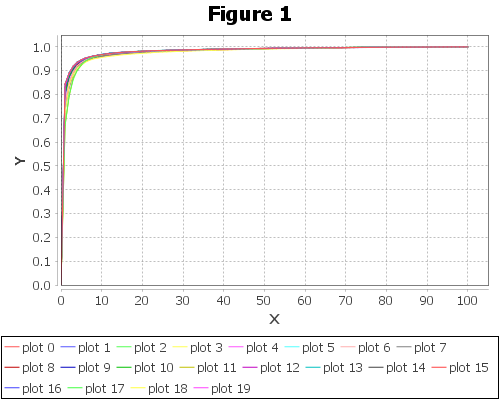

In [14]:
plot(rocs)

In [15]:
val aucs = mean(rocs)

0.97689,0.97628,0.97271,0.97097,0.97659,0.97679,0.97456,0.97251,0.97606,0.97698,0.97540,0.97161,0.97517,0.97693,0.97605,0.97278,0.97390,0.97665,0.97632,0.97352

The maxi2 function will find the max value and its index.

In [16]:
val (bestv, besti) = maxi2(aucs)

9

And using the best index we can find the optimal parameters:

In [17]:
texpparams(besti) \ lrateparams(besti)

0.50000,0.10000

> Write the optimal values in the cell below:

<b>Note:</b> although our parameters lay in a square grid, we could have enumerated any sequence of pairs, and we could have searched over more parameters. The learner infrastructure supports more intelligent model optimization (e.g. Bayesian methods). 